## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [8]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
#from model3D import *
from model3D_small import *
import math
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.np_utils  import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##### Data Description

In [9]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [10]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
print(meta_data.head())

               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4


In [11]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

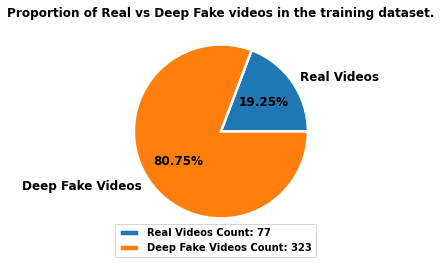

In [12]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

## Frames

In [61]:
def get_frames_v1(paths: list, frames_each_video: int, video_amount: int) -> list:
    video_array_colors = []
    for idx, path in enumerate(paths): 
        if idx == video_amount:
            break
        vc = cv2.VideoCapture(path)
        frames_to_skip = (int(vc.get(cv2.CAP_PROP_FRAME_COUNT))-5)/frames_each_video
        frames_to_skip = math.floor(frames_to_skip)
        video = []
        i = 0
        while vc.isOpened():
            i += 1
            ret, frame = vc.read()
            if ret and frame is not None:
                if i % frames_to_skip != 0:
                    continue
                if frame.shape[0] == 1920:
                    frame = frame.transpose(1, 0, 2)
                frame = cv2.resize(frame, (53, 30))
                video.append((cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255))
            else:
                vc.release()
                break
        #if len(video) < 150:        # for å catch vid me for lite frames
        #    print(len(video), idx)
        #    video.append(video[-1])
        #    print(len(video))
        video_array_colors.append(np.array(video))
    return np.array(video_array_colors)


In [62]:
training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []
for path in paths_col:
    complete_paths.append(train_videoes+"/"+path)
complete_paths.sort()
vid_arr_col = get_frames_v1(paths=complete_paths, frames_each_video=100, video_amount=70)

149 8
150
149 34
150
149 35
150


In [63]:
print(vid_arr_col.shape)
#vid_arr_gray = np.expand_dims(vid_arr_gray, axis=-1)
#print(vid_arr_gray.shape)
print(vid_arr_col[8].shape)

(70, 150, 30, 53, 3)
(150, 30, 53, 3)


In [64]:
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y =np.array(y)
y = to_categorical(y, num_classes=None).astype(int)
y[:10]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [65]:
print(f"Amount of Videos: {len(vid_arr_col)}")
# print(f"Frames for videos: {[len(vid_arr_col[i]) for i in range(len(vid_arr_col))]}")
print(f"Frames for videos: {[len(vid_arr_col[i]) for i in range(10)]}")

Amount of Videos: 70
Frames for videos: [150, 150, 150, 150, 150, 150, 150, 150, 150, 150]


### Plot frames

In [66]:
def plot_video(video: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(len(video[:(width*height)])):
        plt.subplot(width, height, i+1)
        plt.imshow(video[i])
    plt.show()


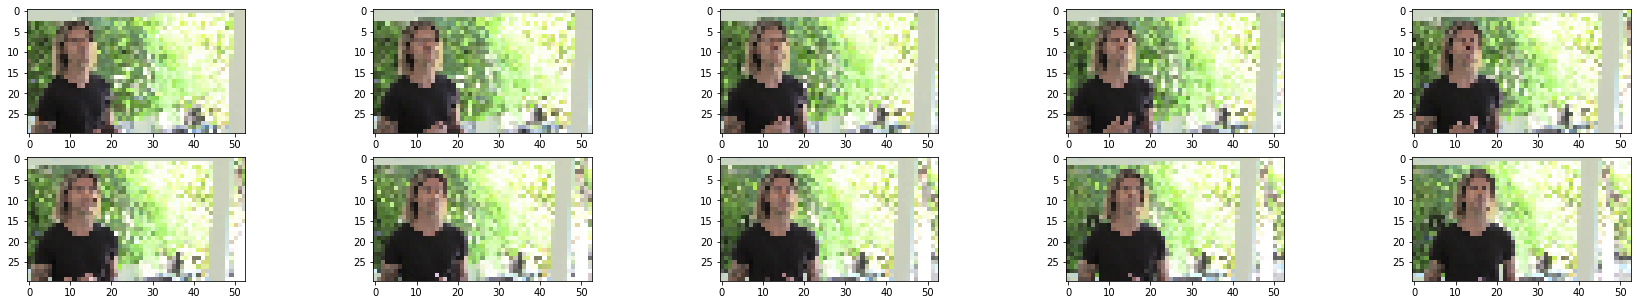

In [67]:
plot_video(vid_arr_col[0], (30,5), 2, 5)

## tSNE

In [ ]:
from sklearn.manifold import TSNE

frames_list = vid_arr_col[0]
frames_array = np.array([frame.flatten() for frame in frames_list])

# Instantiate t-SNE object with desired parameters
tsne = TSNE(n_components=2, perplexity=10, random_state=0)

# Fit t-SNE on the frames array
frames_tsne = tsne.fit_transform(frames_array)

In [ ]:
# Assuming labels is a list of labels corresponding to each frame
plt.scatter(frames_tsne[:,0], frames_tsne[:,1], c=range(0,20))
plt.show()

In [29]:
def format_frames(vid_arr):
    flatten_first_video_frame = vid_arr[0][0]
    flatten_first_video_frame = flatten_first_video_frame / 255
    return np.array([flatten_first_video_frame])

In [30]:
first_frame_formatted = format_frames(vid_arr_col)
first_frame_formatted.shape

(1, 30, 53, 3)

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [31]:
weight_class = compute_class_weight(class_weight='balanced',classes=[0,1],y=np.argmax(y, axis=1))
class_weights = dict(zip(np.unique(y), weight_class))
class_weights

{0: 2.5974025974025974, 1: 0.6191950464396285}

In [32]:
def build_3D_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu", input_shape=input_data.shape[1:]))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=16, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=8, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(2 ,activation="softmax"))
    return model

In [33]:
def test_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=32, kernel_size=(2,2,2),input_shape=input_data.shape[1:],
                activation='relu',
                padding='same', data_format='channels_last'))
    model.add(layers.BatchNormalization())
    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))

    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
    model.add(layers.Flatten())

    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32,activation='elu'))

    model.add(layers.Dense(2,activation='sigmoid'))
    return model

In [68]:
test_m = test_model(vid_arr_col)
test_m.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 150, 30, 53, 32)   800       
                                                                 
 batch_normalization (BatchN  (None, 150, 30, 53, 32)  128       
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 150, 30, 53, 16)   12352     
                                                                 
 batch_normalization_1 (Batc  (None, 150, 30, 53, 16)  64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 150, 30, 53, 16)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 15, 26, 16)  

In [69]:
loss = "binary_crossentropy"
optimizer = "adam"
metrics=["accuracy"]
test_m.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [70]:
history_test = test_m.fit(vid_arr_col, 
                          y[:vid_arr_col.shape[0]],
                          epochs=10, 
                          batch_size=10, 
                          verbose=1, 
                          class_weight=class_weights)

Epoch 1/10
7/7 [==============================] - 214s 29s/step - loss: 5.7187 - accuracy: 0.4429
Epoch 2/10
7/7 [==============================] - 207s 30s/step - loss: 3.6235 - accuracy: 0.5857
Epoch 3/10
7/7 [==============================] - 220s 32s/step - loss: 6.1230 - accuracy: 0.7429
Epoch 4/10
7/7 [==============================] - 224s 32s/step - loss: 4.5268 - accuracy: 0.7143
Epoch 5/10
7/7 [==============================] - 234s 33s/step - loss: 4.3641 - accuracy: 0.7286
Epoch 6/10
7/7 [==============================] - 245s 36s/step - loss: 1.8260 - accuracy: 0.8143
Epoch 7/10
7/7 [==============================] - 250s 36s/step - loss: 2.1516 - accuracy: 0.8714
Epoch 8/10
7/7 [==============================] - 233s 34s/step - loss: 2.1340 - accuracy: 0.8857
Epoch 9/10
7/7 [==============================] - 232s 33s/step - loss: 1.7226 - accuracy: 0.8143
Epoch 10/10
7/7 [==============================] - 236s 33s/step - loss: 1.0189 - accuracy: 0.9000


In [71]:
pred_y = test_m.predict(vid_arr_col)

3/3 [==============================] - 34s 9s/step


In [75]:
pred_y[:5]

array([[8.8938963e-01, 1.5784058e-06],
       [9.6775347e-01, 3.1499878e-06],
       [9.9999279e-01, 2.5655045e-09],
       [4.8019883e-04, 4.6887361e-03],
       [8.7190455e-01, 1.1502287e-06]], dtype=float32)

In [76]:
actual_y = np.argmax(y[:vid_arr_col.shape[0]], axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(actual_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.154     0.909     0.263        11
           1      0.800     0.068     0.125        59

    accuracy                          0.200        70
   macro avg      0.477     0.488     0.194        70
weighted avg      0.698     0.200     0.147        70



In [77]:
pred_y.sum()

5

In [78]:
actual_y

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1], dtype=int64)

In [79]:
cfm = confusion_matrix(actual_y, pred_y)

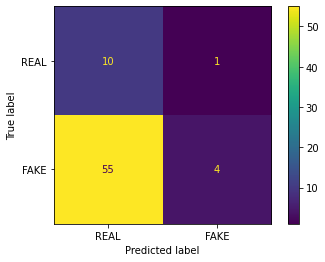

In [80]:
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
disp.plot()

In [ ]:
model_3D_col = build_3D_model(vid_arr_col)
model_3D_col.summary()

In [ ]:
loss = "binary_crossentropy"
optimizer = keras.optimizers.Adam(learning_rate = 0.1)
metrics=["accuracy"]
model_3D_col.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model_3D_col.fit(vid_arr_col, 
                           y[:vid_arr_col.shape[0]],
                           epochs=10, 
                           batch_size=10, 
                           verbose=2)

In [ ]:
#model_3D = build_3D_model(video_array)
model_3D.fit(video_array,y[:video_array.shape[0]],epochs=5,steps_per_epoch=2,batch_size=5)

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]
model_3D.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Plotting performance

In [81]:
print(history_test.params)
print(history_test.history.keys())

{'verbose': 1, 'epochs': 10, 'steps': 7}
dict_keys(['loss', 'accuracy'])


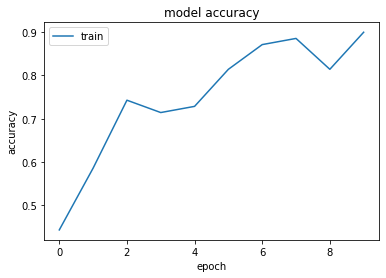

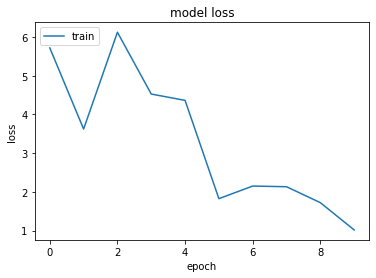

In [83]:
# summarize history for accuracy
plt.plot(history_test.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_test.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()